In [1]:
# Импорты нужных библиотек и функций
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import ztest
from matplotlib import gridspec
from math import ceil

In [2]:
cookies = pd.read_csv('ab_test_cookies.csv')
display(cookies.head())
regs = pd.read_csv('registrations_in_test_period.csv')
display(regs.head(10))
pays = pd.read_csv('purchases_in_test_period.csv')
display(pays.head())

,cookie_id,grp
0,65hj0vyf6kfrckx,A
1,dnjw8oy95td2jqf,B
2,beiyb0xfie92m43,B
3,xyd746tr80pnnbi,B
4,dpq6rqi93zgekgv,A


,cookie_id,user_id
0,NaN,382603
1,NaN,295154
2,NaN,999732
3,NaN,16486
4,NaN,678352
5,NaN,366365
6,hfuu7i04d1bp1zx,61673
7,07wc2gh1g836975,992427
8,9tuf570z8xsu2qy,848957
9,232qku57rxoho0a,226265


,purchase_id,user_id,amount
0,1,275851,350
1,2,923077,1500
2,3,959409,50
3,4,692022,350
4,5,737918,50


In [3]:
#Добавим регистрации к просмотрам лендингов
regs_landing = cookies.merge(regs, on = 'cookie_id', how = 'left')
regs_landing.head()

,cookie_id,grp,user_id
0,65hj0vyf6kfrckx,A,716849.0
1,dnjw8oy95td2jqf,B,NaN
2,beiyb0xfie92m43,B,NaN
3,xyd746tr80pnnbi,B,NaN
4,dpq6rqi93zgekgv,A,NaN


In [4]:
#Группируем платежи по пользователям
pays_groupped = pays.groupby('user_id', as_index = False).agg({'amount':'sum'})
pays_groupped.head()

,user_id,amount
0,0,350
1,27,700
2,33,350
3,61,50
4,76,1500


In [5]:
#Добавляем платежи к информации о регистрациях
ab_table = regs_landing.merge(pays_groupped, on = 'user_id', how = 'left')
ab_table.head(10)

,cookie_id,grp,user_id,amount
0,65hj0vyf6kfrckx,A,716849.0,NaN
1,dnjw8oy95td2jqf,B,NaN,NaN
2,beiyb0xfie92m43,B,NaN,NaN
3,xyd746tr80pnnbi,B,NaN,NaN
4,dpq6rqi93zgekgv,A,NaN,NaN
5,3ftgjuf19unp6fp,A,295330.0,NaN
6,9adgms8hbqndb0j,B,778487.0,NaN
7,gc1kcjt8xik0xhb,B,NaN,NaN
8,g7j3aiw1vbq6zwb,B,205912.0,NaN
9,maeys2kc8tamrba,B,NaN,NaN


In [6]:
#Создадим функцию для получения параметров АБ-теста
def get_ab_parameters(x):
    d = {}
    d['Участников теста'] = x.cookie_id.count()
    d['Количество регистраций'] = x.user_id.count()
    d['Выручка'] = x.amount.sum()
    d['Конверсия в регистрацию, %'] = d['Количество регистраций']/d['Участников теста']*100
    d['Конверсия в покупку, %'] = x.amount.count()/d['Количество регистраций']*100
    d['Конверсия от лендинга в покупку, %'] = x.amount.count()/d['Участников теста']*100
    

    d["АРПУ"] = d['Выручка']/d['Количество регистраций']
    d['Выручка с одного показа'] = d['Выручка']/d['Участников теста']
    d['Средний чек'] = x.amount.mean()

    return pd.DataFrame(d, index = [0])

In [7]:
#Получим параметры АБ-теста
ab_summary = ab_table.groupby('grp').apply(get_ab_parameters).reset_index().drop('level_1', axis = 1).set_index('grp')
ab_summary['Доп. выручка'] = (ab_summary.loc[:, 'Выручка с одного показа'] - \
                              ab_summary.loc['A', 'Выручка с одного показа'])*ab_summary.loc[:, 'Участников теста']
ab_summary

,Участников теста,Количество регистраций,Выручка,"Конверсия в регистрацию, %","Конверсия в покупку, %","Конверсия от лендинга в покупку, %",АРПУ,Выручка с одного показа,Средний чек,Доп. выручка
grp,,,,,,,,,,
A,101329,31439,3216000.0,31.026656,18.496135,5.738732,102.293330,31.738199,553.052451,0.000000
B,151843,41046,5481350.0,27.031868,21.432052,5.793484,133.541636,36.098799,623.093100,662126.598999


In [8]:
#Проверим статзначимость различий конверсии
print('P value для конверсий в регистрацию составляет:',
ztest(ab_table.loc[ab_table.grp == 'A', 'user_id'].apply(lambda x: 1 if pd.notnull(x) else 0),# Конверсии в регистрацию группы А
     ab_table.loc[ab_table.grp == 'B', 'user_id'].apply(lambda x: 1 if pd.notnull(x) else 0) # Конверсии в регистрацию группы B
     )[1] )
print('P value для конверсий в покупку из составляет:', 
ztest(ab_table.loc[(ab_table.grp == 'A')&(pd.notnull(ab_table.user_id))].amount.apply(lambda x: 1 if pd.notnull(x) else 0),# Конверсии в регистрацию группы А
     ab_table.loc[(ab_table.grp == 'B')&(pd.notnull(ab_table.user_id))].amount.apply(lambda x: 1 if pd.notnull(x) else 0) # Конверсии в регистрацию группы B
     )[1] )
print('P value для конверсий в покупку из просмотра лендинга составляет:', 
ztest(ab_table.loc[ab_table.grp == 'A', 'amount'].apply(lambda x: 1 if pd.notnull(x) else 0),# Конверсии в регистрацию группы А
     ab_table.loc[ab_table.grp == 'B', 'amount'].apply(lambda x: 1 if pd.notnull(x) else 0) # Конверсии в регистрацию группы B
     )[1] )

P value для конверсий в регистрацию составляет: 2.0173408788428552e-105
P value для конверсий в покупку из составляет: 1.5044725004087913e-22
P value для конверсий в покупку из просмотра лендинга составляет: 0.5627358282855696


### Вывод:
Конверсия в регистрацию значимо больше в группе А, в покупку из регистрации статзначимо больше в группу В, одноко конверсия из просмотра лендинга в покупку не отличается.

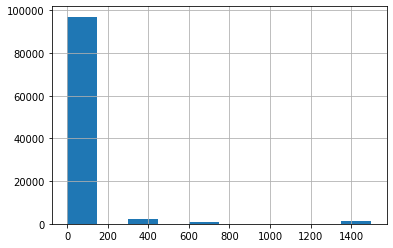

<AxesSubplot:>

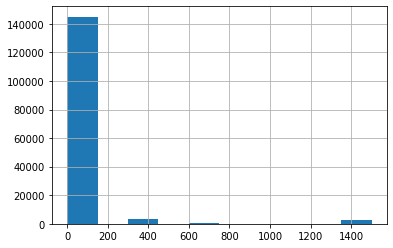

In [9]:
#Посмотрим, как распределены покупки:
ab_table.loc[(ab_table.grp == 'A')].amount.fillna(0).hist()
plt.show()
ab_table.loc[(ab_table.grp == 'B')].amount.fillna(0).hist()

Очевидно, распределение не нормально. Поэтому применим и t-test, и u-test.

Посмотрим значимость различий АРПУ и среднего чека:

In [10]:
#Посмотрим значимость различий АРПУ и среднего чека:
print('Различия по выручке с показа лендинга :',
      stats.mannwhitneyu(ab_table.loc[ab_table.grp == 'A', 'amount'].fillna(0),
     ab_table.loc[ab_table.grp == 'B', 'amount'].fillna(0)),
stats.ttest_ind(ab_table.loc[ab_table.grp == 'A', 'amount'].fillna(0),
     ab_table.loc[ab_table.grp == 'B', 'amount'].fillna(0))
      , sep = '\n')
print('Различия по АРПУ :',
      stats.mannwhitneyu(ab_table.loc[(ab_table.grp == 'A')&(pd.notnull(ab_table.user_id)), 'amount'].fillna(0),
     ab_table.loc[(ab_table.grp == 'A')&(pd.notnull(ab_table.user_id)), 'amount'].fillna(0)),
stats.ttest_ind(ab_table.loc[(ab_table.grp == 'A')&(pd.notnull(ab_table.user_id)), 'amount'].fillna(0),
     ab_table.loc[(ab_table.grp == 'B')&(pd.notnull(ab_table.user_id)), 'amount'].fillna(0))
      , sep = '\n')
print('Различия по среднему чеку :',
      stats.mannwhitneyu(ab_table.loc[(ab_table.grp == 'A')&(pd.notnull(ab_table.user_id)), 'amount'].dropna(0),
     ab_table.loc[(ab_table.grp == 'A')&(pd.notnull(ab_table.user_id)), 'amount'].fillna(0)),
stats.ttest_ind(ab_table.loc[(ab_table.grp == 'A')&(pd.notnull(ab_table.user_id)), 'amount'].dropna(0),
     ab_table.loc[(ab_table.grp == 'B')&(pd.notnull(ab_table.user_id)), 'amount'].fillna(0))
      , sep = '\n')

Различия по выручке с показа лендинга :
MannwhitneyuResult(statistic=7687257761.0, pvalue=0.2131782418227564)
Ttest_indResult(statistic=-5.6615374023743055, pvalue=1.501844531390091e-08)
Различия по АРПУ :
MannwhitneyuResult(statistic=494205360.5, pvalue=0.4999998704935029)
Ttest_indResult(statistic=-12.27214859913644, pvalue=1.3834486877334137e-34)
Различия по среднему чеку :
MannwhitneyuResult(statistic=16907112.5, pvalue=0.0)
Ttest_indResult(statistic=77.92780275090536, pvalue=0.0)


### Вывод:
Хотя согласно тесту Манна-Уитни распределения не отличаются по u-тесту (из-за большой доли покупок в суммой покупки 0 и одинаковыми возможными суммами покупок), Т-тест показывает, что и АРПУ, и выручка с показа баннера статзначимо больше в группе В. Распределения среднего чека, однако, различаются по всем тестам, в группе В средний чек значимо больше.

In [11]:
# Важные функции для получения доверительных интервалов
def get_conf_interval(data, conf_level = 0.95):  # Считает доверительные интервалы для средних
        buf = (stats.t.interval(conf_level, len(data),
                             loc=np.mean(data), scale=stats.sem(data)))
        return (buf[1] - buf[0])/2
    
def get_conf_interval_z(succ, tot):  # Считает доверительные интервалы для бинарных величин
    buf = proportion_confint(succ, tot)
    return buf[1] - buf[0]

def get_conf_interval_z_mas(x):
    return get_conf_interval_z(x.loc[x==1].count(),x.count())

In [12]:
conf_intervals = {'Конверсия в регистрацию, %':{'A':get_conf_interval_z_mas(ab_table.loc[ab_table.grp == 'A',
                                                                 'user_id'].apply(lambda x: 1 if pd.notnull(x) else 0))*100,
                          'B':get_conf_interval_z_mas(ab_table.loc[ab_table.grp == 'B',
                                                    'user_id'].apply(lambda x: 1 if pd.notnull(x) else 0))*100},
                  'Конверсия в покупку, %':{'A':get_conf_interval_z_mas(ab_table.loc[(ab_table.grp == 'A')&
                                        (pd.notnull(ab_table.user_id))].amount.apply(lambda x: 1 if pd.notnull(x) else 0))*100,
                                        'B':get_conf_interval_z_mas(ab_table.loc[(ab_table.grp == 'B')&
                                        (pd.notnull(ab_table.user_id))].amount.apply(lambda x: 1 if pd.notnull(x) else 0))*100},
                  'Конверсия от лендинга в покупку, %':
                  {'A':get_conf_interval_z_mas(ab_table.loc[ab_table.grp == 'A',
                                                        'amount'].apply(lambda x: 1 if pd.notnull(x) else 0))*100,
                          'B':get_conf_interval_z_mas(ab_table.loc[ab_table.grp == 'B',
                                                               'amount'].apply(lambda x: 1 if pd.notnull(x) else 0))*100},
                  'Выручка с одного показа':{'A':get_conf_interval(ab_table.loc[ab_table.grp == 'A',
                                                                 'amount'].fillna(0)),
                          'B':get_conf_interval(ab_table.loc[ab_table.grp == 'B',
                                                    'amount'].fillna(0))},
                  'АРПУ':{'A':get_conf_interval(ab_table.loc[(ab_table.grp == 'A')&
                                        (pd.notnull(ab_table.user_id))].amount.fillna(0)),
                                        'B':get_conf_interval(ab_table.loc[(ab_table.grp == 'B')&
                                        (pd.notnull(ab_table.user_id))].amount.fillna(0))},
                  'Средний чек':
                  {'A':get_conf_interval(ab_table.loc[ab_table.grp == 'A',
                                                        'amount'].dropna()),
                          'B':get_conf_interval(ab_table.loc[ab_table.grp == 'B',
                                                               'amount'].dropna())}
                 }

In [13]:
# Удобная функция для подстановки подписей на barplot
def set_labels(axes):  # Расставляет подписи столбцов на барплоты
    y0, y1 = axes.get_ybound()  # размер графика по оси Y
    y_shift = 0.15* (y1 - y0)  # дополнительное место под надписи

    for i, rect in enumerate(axes.patches):  # по всем нарисованным прямоугольникам
        height = rect.get_height()
        if abs(height) <= 10000:
            label = str(round(height, 2))
            if label[-1] == '0':
                label = label[:-1]
        elif abs(height) <= 1000000:
            label = str(round(height/1000, 1))
            if label[-1] == '0':
                label = label[:-1] + 'k'
            else:
                label = label + 'k'
        else:
            label = str(round(height/1000000, 2))
            if label[-1] == '0':
                label = label[:-1] + 'm'
            else:
                label = label + 'm'
        x = rect.get_x() + rect.get_width() / 2  # посередине прямоугольника
        y = height + y_shift * 0.8  # над прямоугольником в середине доп. места
        if height < 0:
            y = y_shift * 0.8 
        axes.text(x, y, label, ha='center', va='center', alpha = 0.7)
        axes.set_ybound(y0, y1 + 1.5*y_shift)

In [14]:
plot_summary = ab_summary.T# Транспонированная таблица для удобства использования
significant_changes = ['Конверсия в регистрацию, %', 'Конверсия в покупку, %', 'АРПУ',
                      'Выручка с одного показа', 'Средний чек'] # Метрики со статзначимыми различиями

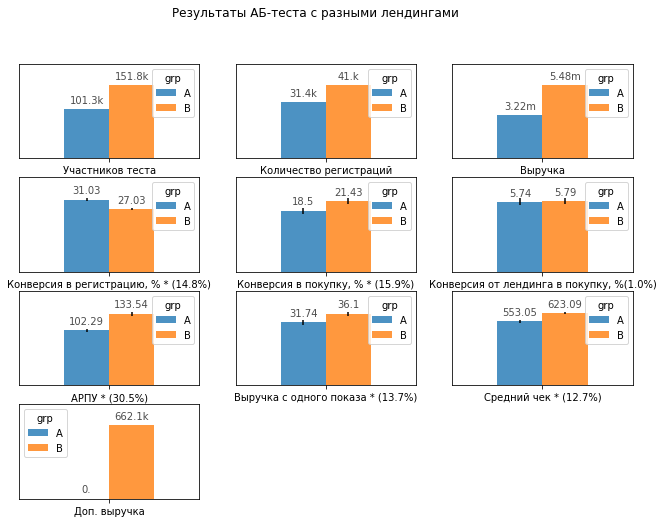

In [15]:
ax = [] # Массив для складирования графиков
n_pict_in_line = 3 # Количество картинок в одной линии

gs = gridspec.GridSpec(ceil(len(plot_summary) / float(n_pict_in_line)), n_pict_in_line) # Создаём сетку для графиков
fig = plt.figure(figsize=(n_pict_in_line*3 + 2,
                          ceil(len(plot_summary) / n_pict_in_line) * 2))

## Считаем изменение метрики в процентах
delta_percent = {}
for row in plot_summary.index:  
    if 'Участников теста' != row and 'Количество регистраций' != row and 'Выручка' != row and "Доп. выручка" != row:
        delta_percent[row] = '(' + str(round(plot_summary.loc[row, :].max()/\
                                  plot_summary.loc[row, :].min()*100 - 100, 1)) + '%)'
        
fig.suptitle('Результаты АБ-теста с разными лендингами')

## Строим графики
for i, col in enumerate(plot_summary.index):
    ax.append(plt.subplot(gs[i // n_pict_in_line, i % n_pict_in_line])) # Добавляем subplot в нужную клетку
    plot_summary.loc[[col], :].plot(kind='bar', rot=0, ax=ax[i], alpha=0.8, # Строим график в нужной клетке
                                   yerr=conf_intervals[col] if col in conf_intervals else 0) 
    
    # Редактируем подпись к графику, чтобы в ней хранилась информация о значимости различий и о 
    stars = ' * ' if col in significant_changes else '' 
    ticks = ax[-1].get_xticklabels()
    ticks[0] = col + stars + delta_percent[col] if col in delta_percent else col + stars
    ax[-1].set_xticklabels(ticks)
    ax[-1].set_yticks([])
    set_labels(axes=ax[i])

### Выводы:

- Показ более длинного баннера, объясняющего все преимущества продукта (группа В), более выгоден, чем показ короткого, но мотивирующего зарегистрироваться (группа А);

- Хотя конверсия в регистрацию и больше в группе В, конверсия в покупку от показа лендинга не отличается в разных группах;

- Пользователи, пришедшие с лендинга В, на 30.5% выгоднее, чем пользователи, пришедшие с лендинга А. Если же считать отправной точкой показ лендинга, то лендинг В выгоднее на 13.7%.

- АРПУ пользователей выросло благодаря росту конверсии и среднего чека, а выручка с показа выросла лишь благодаря росту среднего чека (т.к. конверсия из показа лендирнга в покупку не отличается)


### Рекомендации:
На текущий момент рекомендую оставить лендинг В для привлечения новых клиентов, однако в будущем можно протестировать комбинацию лендинга А и рассказа о преимуществах продукта уже после регистрации: так мы не не только не потеряем конверсию пользователей в регистрацию, но и увеличим их конверсию в покупку и средний чек на платформе. Вполне возможно, такая комбинация действий будет более выгодна, чем просто лендинг В.